### Apprentissage profond - TD n°3
__________
Transfert d'apprentissage (transfer learning)

In [1]:
# imports 
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from PIL import Image


### 1. Introduction

__Modélisation__

On considère un problème d'apprentissage de logos (6 logos de marques de bière, en environnement réel). 
Comment modéliser le problème si : 
- a. on suppose qu'il n'y a qu'un seul logo par image ? 
- b. si on veut pouvoir reconnaître la présence de plusieurs logos par image ? 

a. --> apprentissage supervisé d'un pb de classification multi-classe (à chaque image d'entrainement est associé un unique label).

b. --> apprentissage supervisé d'un pb de classification multi-label (à chaque image d'entrainement est associé un ensemble de labels / un vecteur de taille égale au nombre de classes, avec 1 si la classes est présente, 0 sinon).

### 2. __Préparation des données__

__Chargement__

Les données sont disponibles sur [GoogleDrive](https://drive.usercontent.google.com/download?id=1ec2n18lbI71c0IS7RoixzAe3D67nlEgE&export=download). 

Les images sont groupées par classes (un dossier = une classe). Cela nous permet d'utiliser la fonction `datasets.ImageFolder` de PyTorch afin de charger les données (cf TPs précédents utilisation d'un DataLoader). 

In [2]:
# on lit une première fois les images du dataset
image_directory = "data"

print(os.listdir(image_directory))


['carlsberg', 'chimay', 'corona', 'fosters', 'guiness', 'tsingtao']


__Normalisation__

Dans la suite, on va utiliser un modèle pré-entrainé sur le dataset ImageNet-1k (aussi appelé ILSVRC dataset, 1000 classes tirées de ImageNet-21k, 1.2 millions d'images). On applique aux données cibles une normalisation définie à partir des statistiques calculées sur le dataset source (moyenne et écarts types des valeurs des pixels, entre 0 et 1). On applique aussi un reformatage pour obtenir des images de 224 par 224 pixels.

Dataset source = ImageNet-1k / 
Dataset cible = Beers

In [3]:
# Normalisation des images pour les modèles pré-entraînés PyTorch
# voir: https://pytorch.org/docs/stable/torchvision/models.html
# et ici pour les « explications » sur les valeurs exactes: https://github.com/pytorch/vision/issues/1439
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# première lecture des données
dataset_full = datasets.ImageFolder(image_directory, data_transforms)
print(len(dataset_full))

420


__Motivation__

On dispose seulement de 420 images réparties en 6 classes ! Pas suffisant pour entrainer un réseau de neurones profond de plusieurs millions de paramètres... D'où l'intérêt d'utiliser les poids d'un modèle déjà entrainé sur un autre dataset de plus grande taille. 

In [6]:
# some useful info
print("Classes :", dataset_full.classes)
print("Mapping class to index :", dataset_full.class_to_idx)
print(dataset_full.samples[0]) # check image path

Classes : ['carlsberg', 'chimay', 'corona', 'fosters', 'guiness', 'tsingtao']
Mapping class to index : {'carlsberg': 0, 'chimay': 1, 'corona': 2, 'fosters': 3, 'guiness': 4, 'tsingtao': 5}
('data\\carlsberg\\1179199291.jpg', 0)


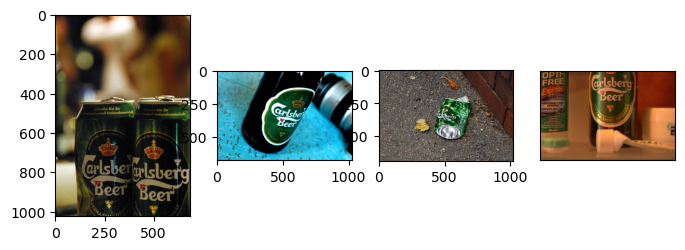

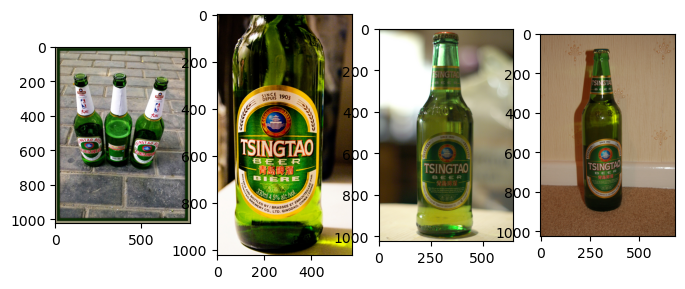

In [7]:
# viz
%matplotlib inline

fig, ax =plt.subplots(1,4, figsize=(8,14))
for ii in range(4) : 
    img_path, label = dataset_full.samples[ii]
    with Image.open(img_path) as img:    
        #img.show() # opens in separate windows
        ax[ii].imshow(img)
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
  
fig, ax =plt.subplots(1,4, figsize=(8,14))
for ii in range(4) : 
    img_path, label = dataset_full.samples[(-ii-1)*10]
    with Image.open(img_path) as img:    
        #img.show() # opens in separate windows
        ax[ii].imshow(img)
  

__Partage des données__ 

Pour cela, utiliser la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) de scikit-learn) avec les proportions suivantes :
- train = 60 % 
- val = 15 %
- test = 25 %

In [32]:
# on split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_train, samples_test = train_test_split(dataset_full.samples, test_size=0.15) # train+val vs test
samples_train, samples_val = train_test_split(samples_train, test_size=0.29) # train vs val

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 253
Nombre d'images de val : 104
Nombre d'images de test : 63


In [37]:
print("Pourcentage d'image dans le train", round(len(samples_train)/len(dataset_full.samples)*100,0), "%")
print("Pourcentage d'image dans le val", round(len(samples_val)/len(dataset_full.samples)*100,0), "%")
print("Pourcentage d'image dans le test", round(len(samples_test)/len(dataset_full.samples)*100,0), "%")

Pourcentage d'image dans le train 60.0 %
Pourcentage d'image dans le val 25.0 %
Pourcentage d'image dans le test 15.0 %


On définit un `DataLoader` pour chacun des sous-ensembles de données. 


In [38]:
# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test

dataset_train = datasets.ImageFolder(image_directory, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, 
                                           shuffle=True, num_workers=4)

dataset_val = datasets.ImageFolder(image_directory, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

dataset_test = datasets.ImageFolder(image_directory, data_transforms)
dataset_test.samples = samples_test
dataset_test.imgs = samples_test

Vérification : toutes les classes doivent être représentées dans le jeu de données d'entrainement.

In [39]:
# détermination du nombre de classes (nb_classes=6)
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
# nb_classes = len(dataset_train.classes)
print("Apprentissage sur {} classes".format(nb_classes))


Apprentissage sur 6 classes


*Reproductibilité et sources d'aléatoire*

A votre avis, où se situent les sources d'aléatoire lorsque vous entrainez un réseau de neurones avec un framework d'apprentissage profond (PyTorch / TensorFlow) ? Y-a-t-il des sources d'aléatoire à l'inférence ? 

Liens utiles : [documentation pytorch](https://pytorch.org/docs/stable/notes/randomness.html), [un exemple chez Weight&Biases](https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy)

In [40]:
torch.manual_seed(42)

???????? JE NE SAIS PAS JE COMPRENDS PAS VRAIMENT LA QUESTION NON PLUS -- TO DO -- VOIR LA CORRECTION

__Chargement d'un modèle pré-entrainé__

Ici on utilise un réseau convolutif de type ResNet18, pré-entrainé sur ImageNet-1k. 
NB : jeter un oeil aux [modèles disponibles via pytorch](https://pytorch.org/vision/stable/models.html). Pour les architecures à base de transformers, de nombreux modèles sont aussi disponibles via le hub et les librairies [huggingface](https://huggingface.co/models).

In [41]:
# Récupérer un réseau pré-entraîné (resnet-18)
print("Récupération du ResNet-18 pré-entraîné...")
my_net = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1') 

# The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
# The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. 
# You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


Récupération du ResNet-18 pré-entraîné...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\clemm/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [01:08<00:00, 686kB/s] 


In [42]:
# architecture
print(my_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

On voit que la dernière couche, nommée `fc`, prend en entrée des vecteurs de taille 512. A quoi correspond `in_features` ? et `out_features` ? 

fc est le bloc de classification depuis l'espace mappé a l'espace de sortie. Il utilise un modèle linéeaire. Cette étape est faite dans une fully connected laye d'ou le nom fc.
in_features (dans fc in_features=512) correspond au 512 caractéristiques d'entrée (entrainé sur ImageNet ??)
out_features (dans fc , out_features=1000) correspond aux classes de sorties

Pour l'adapter a notre projet il faut modifier cette couche par  nn.Linear(nb_features, 6) # 6 pour les 6 classes que nous cherchons a prédire

### 3. Transfert d'apprentissage

Dans le cadre du __transfert d'apprentissage__, *on n'optimise pas les poids du réseau pré-entrainé sur nos données cibles*. On remplace simplement la __couche de classification__ du réseau pré-entrainé par une nouvelle couche de classification, avec une taille adaptée au nombre de classes de notre problème. 

Pour apprendre à classer les images du dataset cible, __on fige les poids du réseau pré-entrainé__ (partie "extraction de caractéristiques" / *feature extractor*) et on optimise les poids de la nouvelle couche de classification (partie "décision", une couche linéaire ici).

In [43]:
# on indique qu'il est inutile de calculer les gradients des paramètres du réseau
for param in my_net.parameters():
    param.requires_grad = False

In [49]:
# on remplace la dernière couche fully connected à 1000 sorties (classes d'ImageNet) par une fully connected à 6 sorties (nos classes).
# par défaut, les gradients des paramètres cette couche seront bien calculés
#  NB: par défaut, la couche réinitialisée a .requires_grad=True
my_net.fc = nn.Linear(in_features=512, out_features=6, bias=True)
# on pourrait aussi réinitaliser d'autres couches e.g. my_net.layer4[1].conv2


In [50]:
# on utilisera le GPU (beaucoup plus rapide) si disponible, sinon on utilisera le CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu") # forcer en CPU s'il y a des problèmes de mémoire GPU (+ être patient...)

In [51]:
my_net.to(device) # on utilise le GPU / CPU en fonction de ce qui est disponible

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

__Entrainement et évaluation__

On donne une fonction d'entrainement et une fonction d'évaluation (cf TPs précédents).

In [52]:
# on définit une fonction d'évaluation
def evaluate(model, dataset, criterion):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)


In [53]:
# fonction classique d'entraînement d'un modèle, voir TDs précédents
PRINT_LOSS = True
def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10):
    for epoch in range(n_epochs): # à chaque epochs
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train): # itère sur les minibatchs via le loader apprentissage
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # on passe les données sur CPU / GPU
            optimizer.zero_grad() # on réinitialise les gradients
            outputs = model(inputs) # on calcule l'output
            
            loss = criterion(outputs, labels) # on calcule la loss
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(my_net, data_val, criterion)
                model.train(True)
                print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() # on effectue la backprop pour calculer les gradients
            optimizer.step() # on update les gradients en fonction des paramètres


On définit une fonction de coût et un optimiseur. Quelle valeur de taux d'apprentissage utiliser ?

--> On utilise un faible taux d'apprentissage (e.g., learning rate fixé à 0.001) car on n'a besoin que d'optimiser la dernière couche du réseau.

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.fc.parameters(), lr=0.001, momentum=0.9)

In [55]:
my_net.train(True) # NB : pas indispensable ici comme on a fixé la partie extraction de features, 
# mais bonne pratique de façon générale
# permet notamment d'activer / désactiver le dropout selon qu'on entraîne ou teste le modèle
print("\nApprentissage en transfer learning")

train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)



Apprentissage en transfer learning
EPOCH  0
0 loss train: 2.0036	 val 0.1306	Acc (val): 22.1%
1 loss train: 1.8949	 val 0.1294	Acc (val): 20.2%
2 loss train: 1.8198	 val 0.1279	Acc (val): 20.2%
3 loss train: 1.9344	 val 0.1267	Acc (val): 21.2%
4 loss train: 1.7812	 val 0.1248	Acc (val): 21.2%
5 loss train: 1.7384	 val 0.1228	Acc (val): 19.2%
6 loss train: 1.7229	 val 0.1210	Acc (val): 20.2%
7 loss train: 1.7857	 val 0.1195	Acc (val): 23.1%
EPOCH  1
0 loss train: 1.6716	 val 0.1186	Acc (val): 24.0%
1 loss train: 1.7077	 val 0.1176	Acc (val): 20.2%
2 loss train: 1.6614	 val 0.1175	Acc (val): 19.2%
3 loss train: 1.7288	 val 0.1168	Acc (val): 22.1%
4 loss train: 1.6007	 val 0.1163	Acc (val): 24.0%
5 loss train: 1.5357	 val 0.1155	Acc (val): 25.0%
6 loss train: 1.6939	 val 0.1149	Acc (val): 25.0%
7 loss train: 1.7479	 val 0.1133	Acc (val): 28.8%
EPOCH  2
0 loss train: 1.7078	 val 0.1111	Acc (val): 28.8%
1 loss train: 1.5685	 val 0.1077	Acc (val): 35.6%
2 loss train: 1.4735	 val 0.1059	Acc 

In [56]:
# évaluation
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))


Accuracy (test): 68.3%


### 4. Adaptation fine des poids du réseau (*fine-tuning*)

On réinitialise le réseau. Cette fois-ci, on va en utiliser les images de notre dataset cible pour mettre à jour (en totalité ou en partie) les paramètres du modèle dans les couches antérieures à la couche de décision. 

In [80]:
# on réinitialise le modèle resnet
my_net = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1') 

In [81]:
my_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [82]:
my_net.fc = nn.Linear(in_features=512, out_features=6, bias=True)
my_net.to(device)

# cette fois on veut mettre à jour tous les paramètres
params_to_update = my_net.parameters()

Remarque :  il est possible de ne sélectionner que quelques couches (plutôt parmi les "dernières", les plus proches de la couche de classificaiton et du calcul de la fonction de coût).

In [83]:
# Exemple : ici on restreint les couches dont on veut mettre à jour les paramètres

list_of_layers_to_finetune=['fc.weight','fc.bias','layer4.1.conv2.weight','layer4.1.bn2. bias','layer4.1.bn2.weight']

params_to_update=[]
for name,param in my_net.named_parameters():
    if name in list_of_layers_to_finetune:
        print("fine tune ",name)
        params_to_update.append(param)
        param.requires_grad = True
    else:
        param.requires_grad = False

# sanity check 
print("Couches mises à jour :")
for name, param in my_net.named_parameters() : 
    if param.requires_grad :
        print(name)


fine tune  layer4.1.conv2.weight
fine tune  layer4.1.bn2.weight
fine tune  fc.weight
fine tune  fc.bias
Couches mises à jour :
layer4.1.conv2.weight
layer4.1.bn2.weight
fc.weight
fc.bias


On utilise un taux d'apprentissage relativement bas, on ne veut pas modifier brutalement les poids du réseau.

In [84]:
# définition de la fonction de coût et de l'optimiseur 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


In [85]:
# on ré-entraîne
print("Apprentissage avec fine-tuning")
my_net.train(True)
torch.manual_seed(42)
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)


Apprentissage avec fine-tuning
EPOCH  0
0 loss train: 2.0324	 val 0.1308	Acc (val): 18.3%
1 loss train: 1.9334	 val 0.1300	Acc (val): 19.2%
2 loss train: 1.9284	 val 0.1286	Acc (val): 21.2%
3 loss train: 1.8302	 val 0.1274	Acc (val): 20.2%
4 loss train: 1.8517	 val 0.1269	Acc (val): 22.1%
5 loss train: 1.8239	 val 0.1266	Acc (val): 22.1%
6 loss train: 1.8582	 val 0.1259	Acc (val): 23.1%
7 loss train: 1.8912	 val 0.1248	Acc (val): 24.0%
EPOCH  1
0 loss train: 1.6937	 val 0.1232	Acc (val): 24.0%
1 loss train: 1.8239	 val 0.1219	Acc (val): 25.0%
2 loss train: 1.6921	 val 0.1207	Acc (val): 25.0%
3 loss train: 1.7882	 val 0.1195	Acc (val): 27.9%
4 loss train: 1.6004	 val 0.1180	Acc (val): 27.9%
5 loss train: 1.6170	 val 0.1163	Acc (val): 30.8%
6 loss train: 1.6467	 val 0.1146	Acc (val): 33.7%
7 loss train: 1.6269	 val 0.1127	Acc (val): 32.7%
EPOCH  2
0 loss train: 1.5086	 val 0.1107	Acc (val): 37.5%
1 loss train: 1.4693	 val 0.1086	Acc (val): 40.4%
2 loss train: 1.4802	 val 0.1069	Acc (val)

In [86]:
# on ré-évalue les performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Accuracy (test): 76.2%


### 5. Autre architecture 

On a utilisé un réseau de type ResNet18 avec 10M de paramètres. Ici on se propose d'utiliser une architecture plus compacte : MobileNetv2 (), qui comporte 2.3M de paramètres. Comparer les architectures. 

In [87]:
# on définit un réseau avec une nouvelle architecture
my_net = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
print(my_net)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [88]:
print(sum(p.numel() for p in my_net.parameters()))
print(sum(p.numel() for p in my_net.parameters() if p.requires_grad))

3504872
3504872


On note que cette architecture ne comporte pas de module `fc` accessible directement comme pour ResNet18 dans la partie précédente. La structure est `features` puis `classifier`.

In [89]:
# remplacement de la couche de classification
my_net.classifier[1] = nn.Linear(in_features=1280, out_features=6, bias=True)
my_net.to(device)

# mise à jour de tous les paramètres
params_to_update = my_net.parameters()

# définition de la fonction de coût et de l'optimiseur 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# entrainement
print("Apprentissage avec fine-tuning\n")
my_net.train(True)
torch.manual_seed(42)
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# évaluation des performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("\nAccuracy (test): %.1f%%" % (100 * accuracy))


Apprentissage avec fine-tuning

EPOCH  0


: 

NB : augmentation drastique de l'accuracy. Ici on a fait 10 epochs comme pour ResNet18 mais l'architecture MobileNetv2 comporte 3,5 fois moins de paramètres. On atteint la convergence plus tôt et la performance continue à s'améliorer.

### 6. Bonus : modélisation multi-labels

En conservant l’hypothèse de classes exclusives (qui est fausse en pratique mais facilite l’annotation) il est néanmoins possible d’apprendre un modèle multi-labels, où chaque classe est reconnue indépendamment. 

Points d'attentions : 
- ici on ne refait pas la labelisation des données, mais on modifie la manière d'entrainer le réseau, pour pouvoir faire une prédiction multi-label  

- définition de la fonction de coût 
> criterion = nn.BCEWithLogitsLoss()

- seuil par défaut pour attribuer un label : 0.5

- possibilité de déterminer un seuil de décision pour chacune des classes en se basant sur le dataset de validation.

- One-hot-encoding avec `torch.nn.one_hot_encoding` cf [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html). Attention, si on ne précise pas le nombre de classes, celui-ci est inféré à partir du nombre de labels différents au sein d'un batch, mais cela peut conduire à une erreur si toutes les classes du problème ne sont pas représentées dans un batch donné. D'où l'intérêt de préciser le nombre de classes avec l'argument `num_classes`. 

In [ ]:
# on redéfinit la fonction d'évaluation
# one-hot encoding des labels pour calculer la BCELoss
# pour l'accuracy, comme on ne dispose pas de la vérité terrain pour le cas multilabel, 
# on se rapporte au cas précédent avec un seul label. 
 
def evaluate_multilabel(model, dataset, criterion):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        oh_labels = torch.nn.functional.one_hot(labels, num_classes = nb_classes) 
        oh_labels = oh_labels.type(torch.FloatTensor)
        inputs, oh_labels = inputs.to(device), oh_labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, oh_labels)
        _, preds = torch.max(outputs, 1) 
        n_correct = torch.sum(preds.to("cpu") == labels)
        # autre méthode
        # pred = outputs.argmax(dim=1, keepdim=True)
        # gt = oh_labels.argmax(dim=1, keepdim=True)
        # n_correct = pred.eq(gt.view_as(pred)).sum().item()

        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)


In [ ]:
# fonction classique d'entraînement d'un modèle, voir TDs précédents
PRINT_LOSS = True
def train_model_multilabel(model, loader_train, data_val, optimizer, criterion, n_epochs=10):
    for epoch in range(n_epochs): # à chaque epochs
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train): # itère sur les minibatchs via le loader apprentissage
            inputs, labels = data
            labels = torch.nn.functional.one_hot(labels, num_classes = nb_classes)
            labels = labels.type(torch.FloatTensor)
            inputs, labels = inputs.to(device), labels.to(device) # on passe les données sur CPU / GPU
            optimizer.zero_grad() # on réinitialise les gradients
            outputs = model(inputs) # on calcule l'output
            
            loss = criterion(outputs, labels) # on calcule la loss
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(model, data_val, criterion)
                model.train(True)
                print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() # on effectue la backprop pour calculer les gradients
            optimizer.step() # on update les gradients en fonction des paramètres


In [ ]:
# exemple avec mobilenet v2
my_net = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
my_net.classifier[1] = nn.Linear(in_features=my_net.classifier[1].in_features, out_features=nb_classes, bias=True)
my_net.to(device)

# mise à jour de tous les paramètres
params_to_update = my_net.parameters()

# définition de la fonction de coût et de l'optimiseur 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# entrainement
print("Apprentissage avec fine-tuning")
my_net.train(True)
torch.manual_seed(42)
train_model_multilabel(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# évaluation des performances
my_net.train(False)
loss, accuracy = evaluate_multilabel(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\clemm/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 27.6MB/s]


Apprentissage avec fine-tuning
EPOCH  0


KeyboardInterrupt: 

Pour aller plus loin : quel pourcentage d'images comporte au moins 2 logos de marques différentes selon le modèle ? comment choisir des seuils de décision adaptés à chacune des classes ? 

### 7. Adaptation de modèles ViT et ResNet-18 Huggingface

Huggingface donne accès à de nombreux modèles open-source (PyTorch et autres). 
Sa librairie principale est `transformers`, elle facilite la manipulation des modèles disponibles. 
Nous allons ici utiliser PyTorch Image Models, aka `timm`, qui a un fonctionnement semblable.

Jetons un oeil aux modèles disponibles via `timm`. 

In [69]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained = True)
pprint(model_names)
print("Number of available models", len(model_names))

ModuleNotFoundError: No module named 'timm'

__ResNet18__

Il est possible de refaire l’adaptation d’un ResNet-18 en chargeant le modèle suivant. Reproduisez l'apprentissage par transfert effectué précédemment avec le modèle pré-entrainé issu du hub PyTorch. 

In [33]:
# resnet18, this time with timm
my_net = timm.create_model('resnet18.a1_in1k', pretrained = TODO , num_classes =TODO)
my_net.fc = nn.Linear(in_features=TODO, out_features=TODO, bias=TODO)

print(my_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [34]:
# training with default HPs (lr=0.001, momentum=0.9, 10 epochs)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.fc.parameters(), lr=0.001, momentum=0.9)

my_net = my_net.to(device)
my_net.train(True) 
print("\nApprentissage en transfer learning")
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)


Apprentissage en transfer learning
EPOCH  0
0 loss train: 1.8093	 val 0.1115	Acc (val): 20.6%
1 loss train: 1.8169	 val 0.1115	Acc (val): 20.6%
2 loss train: 1.8112	 val 0.1116	Acc (val): 23.8%
3 loss train: 1.8263	 val 0.1117	Acc (val): 22.2%
4 loss train: 1.7617	 val 0.1117	Acc (val): 22.2%
5 loss train: 1.7954	 val 0.1117	Acc (val): 22.2%
6 loss train: 1.8264	 val 0.1117	Acc (val): 23.8%
7 loss train: 1.8049	 val 0.1116	Acc (val): 25.4%
EPOCH  1
0 loss train: 1.8054	 val 0.1116	Acc (val): 28.6%
1 loss train: 1.7795	 val 0.1116	Acc (val): 25.4%
2 loss train: 1.8071	 val 0.1116	Acc (val): 27.0%
3 loss train: 1.8214	 val 0.1115	Acc (val): 27.0%
4 loss train: 1.7616	 val 0.1115	Acc (val): 25.4%
5 loss train: 1.7701	 val 0.1115	Acc (val): 27.0%
6 loss train: 1.8055	 val 0.1115	Acc (val): 27.0%
7 loss train: 1.7454	 val 0.1114	Acc (val): 25.4%
EPOCH  2
0 loss train: 1.7668	 val 0.1114	Acc (val): 25.4%
1 loss train: 1.7634	 val 0.1115	Acc (val): 22.2%
2 loss train: 1.7781	 val 0.1115	Acc 

In [36]:
# évaluation des performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Accuracy (test): 36.2%


* Les performances sont bien inférieures à celles obtenues précédemment (comparer les accuracies de validation au cours des entrainements, ainsi que les accuracies de test). Pourquoi ces différences ? 

Réponse : Consulter [la documentation `timm` associée au modèle](https://huggingface.co/timm/resnet18.a1_in1k). Il ne s'agit pas exactement du même modèle ! Certes le checkpoint téléchargé via `timm` correspond bien à une architecture ResNet18, et à un entrainement sur le dataset ImageNet-1k, mais les __hyperparmètres__ utilisés par les auteurs ne sont pas les mêmes que pour le modèle précédent ! En particulier, la procédure d'optimisation, et l'augmentation de données, cf [l'article en question](https://arxiv.org/abs/2110.00476). 

==> *Assurez-vous de bien comprendre comment le modèle que vous ré-utilisez a été obtenu !*

* Comment résoudre ce problème ? 

Réponse : Cherchons de nouveaux hyperparamètres pour l'apprentissage (cf cours sur la recherche d'hyperparamètres). En particulier le taux d’apprentissage était fixé à 0.001 pour le programme précédent.
En regardant les performances en validation ci-dessus, on voit que les performances en validation patinent et que aussi que la convergence n’est pas terminée. On essaye avec un learning rate plus grand et un nombre d'epochs plus grand aussi.

In [ ]:
my_net = timm.create_model('resnet18.a1_in1k', pretrained = TODO , num_classes =TODO)
my_net.fc = nn.Linear(in_features=TODO, out_features=TODO, bias=TODO)
my_net = my_net.to(device)

# training with new HPs
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.fc.parameters(), lr=0.02, momentum=0.9)
my_net.train(True) 
print("\nApprentissage en transfer learning")
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=15)


Apprentissage en transfer learning
EPOCH  0
0 loss train: 1.8305	 val 0.1134	Acc (val): 17.5%
1 loss train: 1.7834	 val 0.1132	Acc (val): 22.2%
2 loss train: 1.7805	 val 0.1131	Acc (val): 22.2%
3 loss train: 1.7953	 val 0.1122	Acc (val): 23.8%
4 loss train: 1.7601	 val 0.1108	Acc (val): 28.6%
5 loss train: 1.7938	 val 0.1101	Acc (val): 33.3%
6 loss train: 1.7436	 val 0.1097	Acc (val): 30.2%
7 loss train: 1.6940	 val 0.1098	Acc (val): 23.8%
EPOCH  1
0 loss train: 1.6996	 val 0.1097	Acc (val): 15.9%
1 loss train: 1.5714	 val 0.1090	Acc (val): 22.2%
2 loss train: 1.6556	 val 0.1087	Acc (val): 30.2%
3 loss train: 1.6716	 val 0.1079	Acc (val): 30.2%
4 loss train: 1.6028	 val 0.1063	Acc (val): 27.0%
5 loss train: 1.6107	 val 0.1039	Acc (val): 33.3%
6 loss train: 1.4280	 val 0.1012	Acc (val): 42.9%
7 loss train: 1.4195	 val 0.0985	Acc (val): 57.1%
EPOCH  2
0 loss train: 1.3752	 val 0.0958	Acc (val): 71.4%
1 loss train: 1.3799	 val 0.0935	Acc (val): 71.4%
2 loss train: 1.4816	 val 0.0915	Acc 

In [39]:
# évaluation des performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Accuracy (test): 73.3%


__ViT__

Sélectionner un modèle de type ViT (conseil : tiny ViT pour que les calculs soient faisables sur votre ordinateur personnel) et adaptez la couche de sortie. Mesurez les performances.

In [40]:
# print all models whose name begins with "tiny_vit"
pprint(timm.list_models('tiny_vit*', pretrained = True ))

['tiny_vit_5m_224.dist_in22k',
 'tiny_vit_5m_224.dist_in22k_ft_in1k',
 'tiny_vit_5m_224.in1k',
 'tiny_vit_11m_224.dist_in22k',
 'tiny_vit_11m_224.dist_in22k_ft_in1k',
 'tiny_vit_11m_224.in1k',
 'tiny_vit_21m_224.dist_in22k',
 'tiny_vit_21m_224.dist_in22k_ft_in1k',
 'tiny_vit_21m_224.in1k',
 'tiny_vit_21m_384.dist_in22k_ft_in1k',
 'tiny_vit_21m_512.dist_in22k_ft_in1k']


Essayez de décoder ces noms de modèles ! Quelques indices (et consulter la documentation des modèles sur le site de Huggingface) : 
- dist = distilled, 
- ft = fine-tuned, 
- in22k = ImageNet complet à +21k classes, 
- in1k = ImageNet-1k utilisé dans le cadre du challenge ILSVRC, 
- 284/384/512 = taille des images à l'entrainement
- ...

Dans la suite, nous choisissons un modèle de type ViT-tiny avec 5 millions de paramètres, entrainé sur les images de ImageNet-1k en résolution 224 x 224 ([cf documentation](https://huggingface.co/timm/tiny_vit_5m_224.in1k) ).

In [41]:
my_net = timm.create_model( 'tiny_vit_5m_224.in1k' , pretrained = True , num_classes =6)
my_net.head.fc = nn.Linear(in_features = my_net.head.fc.in_features , out_features = 6 , bias = True )
my_net = my_net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.head.fc.parameters(), lr=0.001, momentum=0.9)

# adaptation de la couche de classif
my_net.train(True) 
print("\nApprentissage en transfer learning")
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# évaluation
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))


Apprentissage en transfer learning
EPOCH  0


NB : On est limité par la puissance de calcul disponible (e.g. une GPU de 4G est insuffisante pour du fine-tuning ici). A titre indicatif, on peut obtenir des performances de l'ordre de 71.4% d'accuracy en transfert et 82.9% en finetuning. Mais les performances varient avec les conditions initiales.

__Remarque pratique__ : Où les checkpoints sont-ils téléchargés ? Vérifiez par vous-même :

Dans le cas de `torch`:

> ll $HOME/.cache/torch

Dans le cas de `timm`: 

> ll $HOME/.cache/huggingface/hub

